In [2]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import glob

# df_orig = pd.read_csv("2023_09_S06_1937_E06_2012Z-0400_outdoor_NBM_S_7ed6caec_cbrs_nav_cell.csv")
# df_orig_cols = df_orig.columns.tolist()

fix_pci = 165
fix_freq = 3670e6

bs2_lat = 41.66351428764127
bs2_lon = -86.25556879429736
bs2_height = 55

# for file in csv_files:
#     df = pd.read_csv(file)
#     if fix_pci in df['pci'].values:
#         print(file)

csv_files = glob.glob('data/sigcap_data/*.csv')
filtered_dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    filtered_df = df[df['pci'] == fix_pci]
    filtered_df = filtered_df[['latitude', 'longitude', 'pci', 'rsrp']]
    filtered_df['file_name'] = file
    filtered_dfs.append(filtered_df)
df_fix_pci = pd.concat(filtered_dfs)
# df_fix_pci.to_csv('fix_pci_filtered_data.csv', index=False)

del filtered_dfs, filtered_df, df, csv_files, file

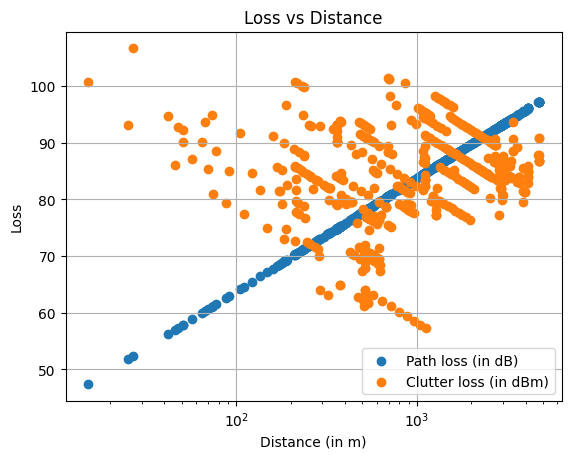

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Calculate the differences between the latitudes and longitudes
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Apply the Haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371  # Radius of the Earth in kilometers

    # Calculate the distance in km
    distance = c * r
    return distance

df_fix_pci['distance'] = haversine(df_fix_pci['latitude'], df_fix_pci['longitude'], bs2_lat, bs2_lon)*1e3
df_fix_pci['calc_path_loss'] = 20 * np.log10((4 * np.pi * df_fix_pci['distance']) * fix_freq / (3*10e8))

df_fix_pci['calc_theta'] = np.rad2deg(np.arctan(bs2_height / df_fix_pci['distance']))

dist_min = df_fix_pci['distance'].min()
dist_max = df_fix_pci['distance'].max()
dist_mean = df_fix_pci['distance'].mean()
dist_std_dev = df_fix_pci['distance'].std()

theta_min = df_fix_pci['calc_theta'].min()
theta_max = df_fix_pci['calc_theta'].max()
theta_mean = df_fix_pci['calc_theta'].mean()
theta_std_dev = df_fix_pci['calc_theta'].std()

# def path_loss(dist, freq):
#     return 20 * np.log10((4 * np.pi * dist) * freq / (3 * 10e8))

# dist_temp = np.linspace(dist_min, dist_max, 100)
# plt.semilogx(dist_temp, path_loss(dist_temp,fix_freq), linestyle='dashed', color='red')
# plt.legend(['Free path loss (in dB)'])

df_fix_pci['clutter_loss'] = 50 - df_fix_pci['calc_path_loss'] - df_fix_pci['rsrp']

plt.semilogx([],[],label='_nolegend_')
plt.scatter(df_fix_pci['distance'], df_fix_pci['calc_path_loss'])
plt.scatter(df_fix_pci['distance'], df_fix_pci['clutter_loss'])
plt.legend(['Path loss (in dB)', 'Clutter loss (in dBm)'])
plt.xlabel('Distance (in m)')
plt.ylabel('Loss')
plt.title('Loss vs Distance')
plt.grid()
plt.show()

# del dist_temp

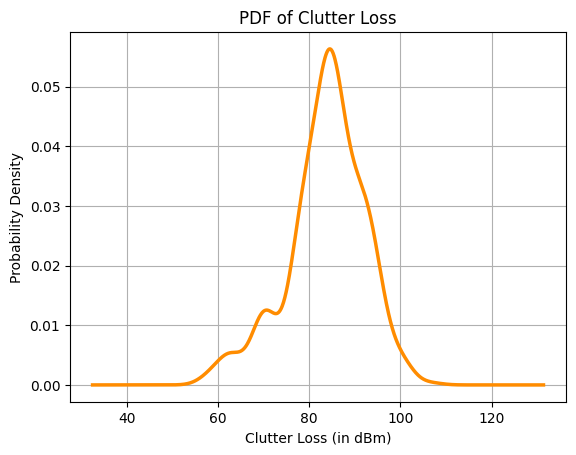

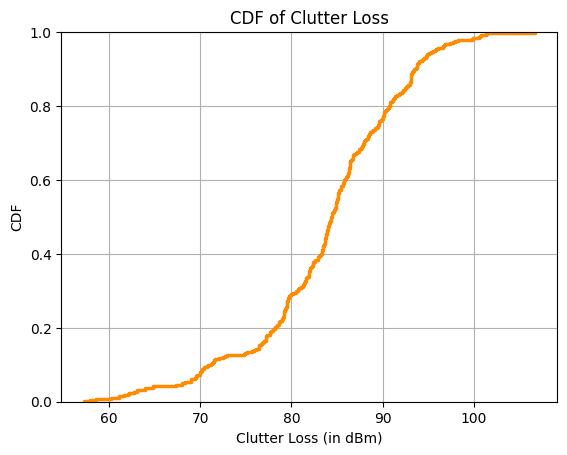

In [4]:
clutter_loss_mean = df_fix_pci['clutter_loss'].mean()
clutter_loss_std_dev = df_fix_pci['clutter_loss'].std()
clutter_loss_min = df_fix_pci['clutter_loss'].min()
clutter_loss_max = df_fix_pci['clutter_loss'].max()

df_fix_pci['clutter_loss'].plot(kind='density', linewidth=2.5, color='darkorange')
plt.xlabel('Clutter Loss (in dBm)')
plt.ylabel('Probability Density')
plt.title('PDF of Clutter Loss')
plt.grid()
plt.show()

# clutter_loss_values = df_fix_pci['clutter_loss'].values
# sorted_clutter_loss = np.sort(clutter_loss_values)
# cdf = np.arange(1, len(sorted_clutter_loss) + 1) / len(sorted_clutter_loss)
# plt.plot(sorted_clutter_loss, cdf)
# plt.xlabel('Clutter Loss (in dB)')
# plt.ylabel('CDF')
# plt.title('CDF of Calculated Clutter Loss')
# plt.grid()
# plt.show()

plt.ecdf(df_fix_pci['clutter_loss'], linewidth=2.5, color='darkorange')
plt.xlabel('Clutter Loss (in dBm)')
plt.ylabel('CDF')
plt.title('CDF of Clutter Loss')
plt.grid()
plt.show()

# del clutter_loss_values, sorted_clutter_loss, cdf

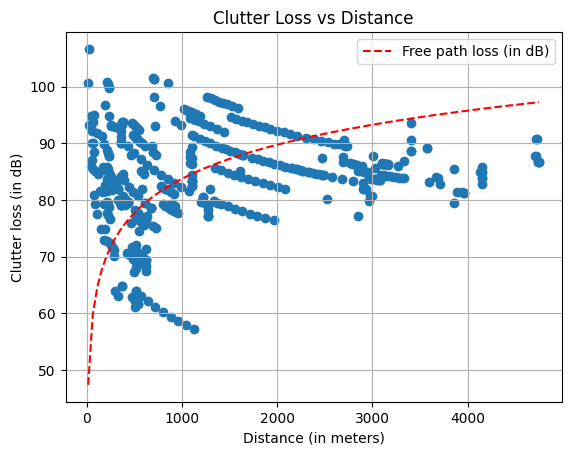

In [5]:
dist_temp = np.linspace(dist_min, dist_max, 100)
path_loss_temp = 20 * np.log10((4 * np.pi * dist_temp) * fix_freq / (3 * 10e8))
plt.plot(dist_temp, path_loss_temp, linestyle='dashed', color='red')
plt.legend(['Free path loss (in dB)'])

del dist_temp, path_loss_temp

plt.scatter(df_fix_pci['distance'], df_fix_pci['clutter_loss'])
plt.xlabel('Distance (in meters)')
plt.ylabel('Clutter loss (in dB)')
plt.title('Clutter Loss vs Distance')
plt.grid()
plt.show()

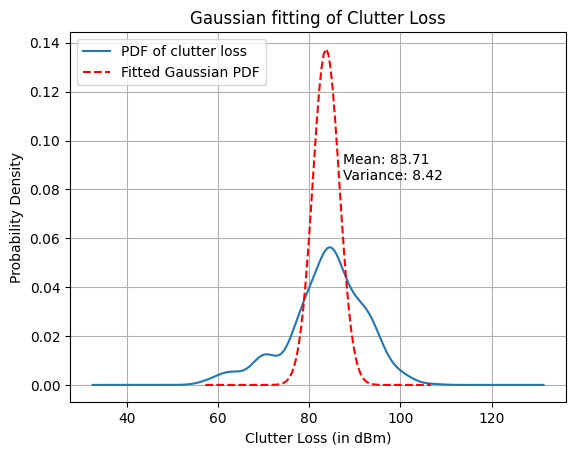

In [6]:
df_fix_pci['clutter_loss'].plot(kind='density')
plt.xlabel('Clutter Loss (in dBm)')
plt.ylabel('Probability Density')
plt.title('Gaussian fitting of Clutter Loss')

# Gaussian fitting
normal_fit_mean, normal_fit_var = stats.norm.fit(df_fix_pci['clutter_loss'])
x_temp = np.linspace(df_fix_pci['clutter_loss'].min(), df_fix_pci['clutter_loss'].max(), 100)
plt.plot(x_temp, stats.norm.pdf(x_temp, normal_fit_mean, np.sqrt(normal_fit_var)), linestyle='dashed', color='red')
plt.legend(['PDF of clutter loss','Fitted Gaussian PDF'], loc="upper left")

plt.text(0.55, 0.6, f"Mean: {normal_fit_mean:.2f}\nVariance: {normal_fit_var:.2f}", transform=plt.gca().transAxes)
plt.grid()
plt.show()

del x_temp

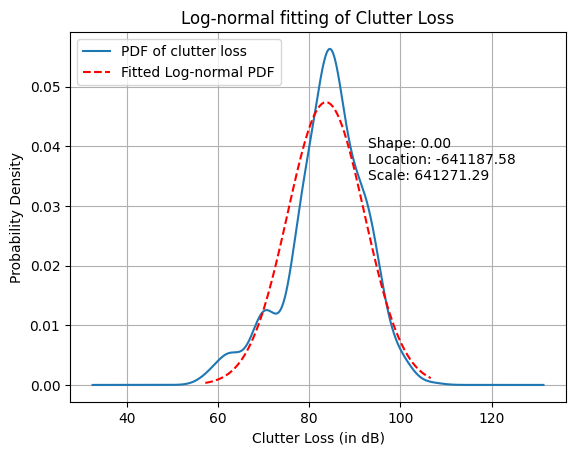

In [7]:
df_fix_pci['clutter_loss'].plot(kind='density')
plt.xlabel('Clutter Loss (in dB)')
plt.ylabel('Probability Density')
plt.title('Log-normal fitting of Clutter Loss')

# Log-normal fitting
lognorm_fit_shape, lognorm_fit_loc, lognorm_fit_scale = stats.lognorm.fit(df_fix_pci['clutter_loss'])
x_temp = np.linspace(df_fix_pci['clutter_loss'].min(), df_fix_pci['clutter_loss'].max(), 100)
plt.plot(x_temp, stats.lognorm.pdf(x_temp, lognorm_fit_shape, lognorm_fit_loc, lognorm_fit_scale), linestyle='dashed', color='red')
plt.legend(['PDF of clutter loss','Fitted Log-normal PDF'], loc="upper left")

plt.text(0.6, 0.6, f"Shape: {lognorm_fit_shape:.2f}\nLocation: {lognorm_fit_loc:.2f}\nScale: {lognorm_fit_scale:.2f}", transform=plt.gca().transAxes)
plt.grid()
plt.show()

del x_temp

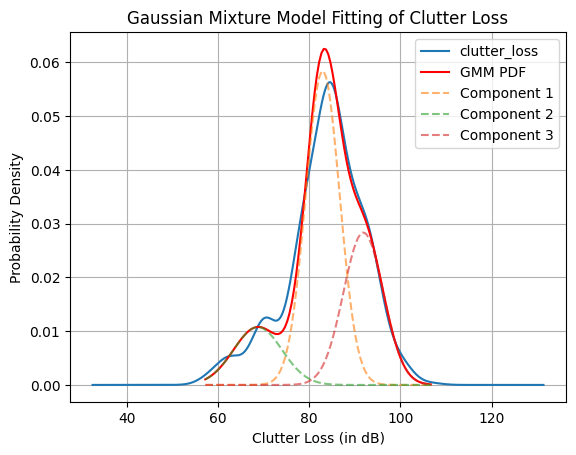

In [8]:
from sklearn.mixture import GaussianMixture

# Fit the data into a Gaussian Mixture Model
gmm = GaussianMixture(n_components=3)  # You can adjust the number of components as needed
gmm.fit(df_fix_pci['clutter_loss'].values.reshape(-1, 1))

# Get the parameters of the fitted GMM
means = gmm.means_
covariances = gmm.covariances_
weights = gmm.weights_

# Generate data points for plotting the PDF
x = np.linspace(df_fix_pci['clutter_loss'].min(), df_fix_pci['clutter_loss'].max(), 100)
pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))

# Plot the histogram of the data
df_fix_pci['clutter_loss'].plot(kind='density')

# Plot the PDF of the fitted GMM
plt.plot(x, pdf, color='red', label='GMM PDF')

# Plot the individual Gaussian components
for i in range(len(means)):
    plt.plot(x, weights[i] * stats.norm.pdf(x, means[i][0], np.sqrt(covariances[i][0][0])), linestyle='dashed', alpha=0.6, label=f'Component {i+1}')

plt.xlabel('Clutter Loss (in dB)')
plt.ylabel('Probability Density')
plt.title('Gaussian Mixture Model Fitting of Clutter Loss')
plt.legend()
plt.grid()
plt.show()





in folder, there are multiple csv files. i need to filter out rows whose pci column value is 165 from each of these csv files. dump these rows in df_pci_165 variable. while dumping the rows, only record the latitude, longitude, altitude, pci and lte-rssi/nr-sinr columns. also, create a new column containing the name of the csv file.

find distance of all rows of df_fix_pci from [bs2_lat, bs2_lon] where coordinates of latitude and longitude are columns in df_fix_pci

find pathloss of each row in df_fix_pci using distance column where path_loss = 20log_10(4*pi*distance/lambda) where frequency=3670MHz

plot scatter graph of lte-rssi/nr-sinr column of df_fix_pci vs distance column of df_fix_pci

want to plot in map the location of each rows of df_fix_pci using longitude and latitude columns in df_fix_pci. at each point in map corresponding to the row's location, describe lte-rssi/nr-sinr column value as heatmap

Find gaussian distribution mean and variance that best fits the pdf of df_fix_pci['clutter_loss']

Find log normal distribution that best fits the pdf of df_fix_pci['clutter_loss'], and plot it along with df_fix_pci['clutter_loss']

fit df_fix_pci['clutter_loss'] into gaussian mixture model and plot the model along with the pdf of fit df_fix_pci['clutter_loss']